In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

%matplotlib inline



In [2]:
#### Input params ##################
stk_path = "C:/Users/KRITIKA/Documents/BIA-656-A/Project/GOOG.csv"

test_size = 0.2                 
cv_size = 0.2                   
Nmax = 21   

fontsize = 14
ticklabelsize = 14


# LINEAR REGRESSION

In [3]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):

    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) 
        y_train = np.array(df['adj_close'][i-N:i])
        X_train = X_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list


In [4]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)
df.tail()

,date,open,high,low,close,adj_close,volume,month
2512,2020-11-10,1731.089966,1763.000000,1717.300049,1740.390015,1740.390015,2636100,11
2513,2020-11-11,1750.000000,1764.219971,1747.364990,1752.709961,1752.709961,1264000,11
2514,2020-11-12,1747.630005,1768.270020,1745.599976,1749.839966,1749.839966,1247500,11
2515,2020-11-13,1757.630005,1781.040039,1744.550049,1777.020020,1777.020020,1499900,11
2516,2020-11-16,1771.699951,1799.069946,1767.689941,1781.380005,1781.380005,1245100,11


In [5]:
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1511
num_cv = 503
num_test = 503
train.shape = (1511, 8)
cv.shape = (503, 8)
train_cv.shape = (2014, 8)
test.shape = (503, 8)


Text(0, 0.5, 'USD')

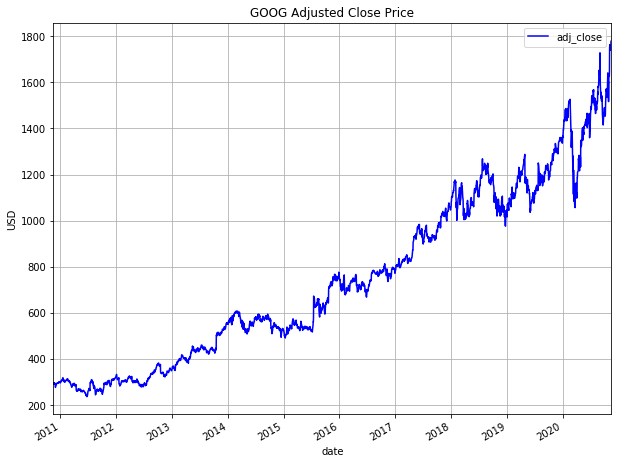

In [6]:
rcParams['figure.figsize'] = 10, 8
ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
plt.title("GOOG Adjusted Close Price")
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0, 0.5, 'USD')

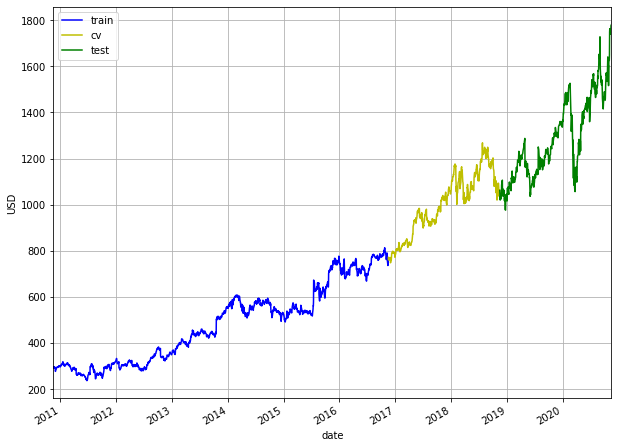

In [7]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'cv', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [8]:
RMSE = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
print('RMSE = ' + str(RMSE))
cv.head()

RMSE = [14.084831524353596, 19.472109447780795, 18.038098443140683, 17.04301845994047, 16.930094498849524, 17.80302860084003, 18.860284563384255, 19.74697708151609, 20.82376442641401, 21.948409864944985, 22.878958447083196, 23.7804121295587, 24.58351926404903, 25.20097559346199, 25.714328045355575, 26.160531291100657, 26.543341200753037, 26.804406982721147, 26.98502853524114, 27.145310391628765, 27.344369629642333]


,date,open,high,low,close,adj_close,volume,month,est_N1,est_N2,...,est_N12,est_N13,est_N14,est_N15,est_N16,est_N17,est_N18,est_N19,est_N20,est_N21
1511,2016-11-17,766.919983,772.700012,764.229980,771.229980,771.229980,1304000,11,764.479980,770.469970,...,754.132423,753.578465,751.969785,751.190770,750.503006,749.317360,748.164387,749.073516,750.310325,751.108199
1512,2016-11-18,771.369995,775.000000,760.000000,760.539978,760.539978,1547100,11,771.229980,777.979980,...,758.773471,757.331146,756.440986,754.603332,753.552002,752.610001,751.219283,749.870705,750.491582,751.458481
1513,2016-11-21,762.609985,769.700012,760.599976,769.200012,769.200012,1330600,11,760.539978,749.849976,...,757.251192,758.127674,756.749547,755.857611,754.066493,752.989702,752.008689,750.598419,749.219157,749.708856
1514,2016-11-22,772.630005,776.960022,767.000000,768.270020,768.270020,1593100,11,769.200012,777.860046,...,757.592863,759.608832,760.160097,758.662944,757.619246,755.737276,754.522484,753.403508,751.882790,750.392049
1515,2016-11-23,767.729980,768.283020,755.250000,760.989990,760.989990,1478400,11,768.270020,767.340028,...,757.279842,759.521146,761.158455,761.507994,759.969247,758.845663,756.929021,755.631583,754.423845,752.833957


(2, 21)

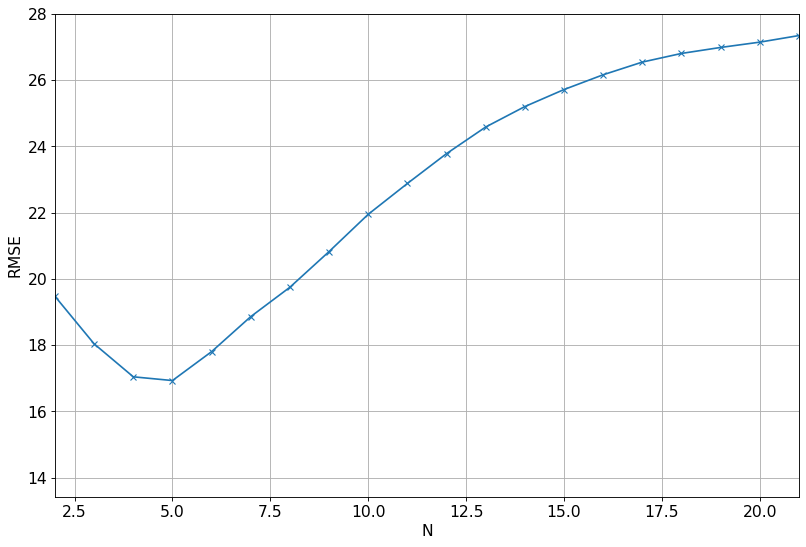

In [9]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])

Text(0, 0.5, 'USD')

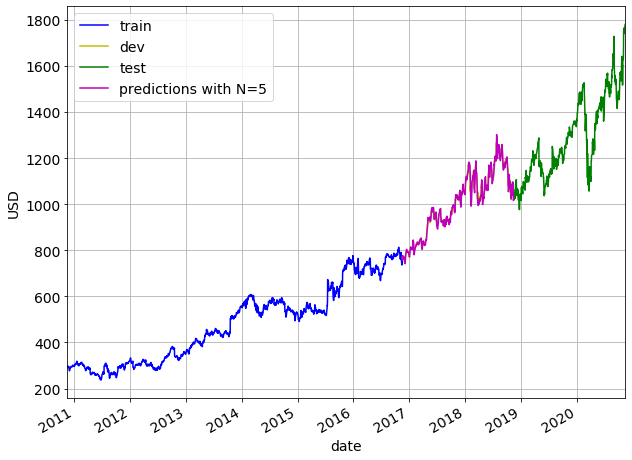

In [10]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
#ax = cv.plot(x='date', y='est_N1', style='r*', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [11]:
#Running the algortihm on test set
N_opt =5
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))

test.head()

RMSE = 30.878


,date,open,high,low,close,adj_close,volume,month,est_N5
2014,2018-11-16,1059.410034,1067.000000,1048.979980,1061.489990,1061.489990,1658100,11,1050.484985
2015,2018-11-19,1057.199951,1060.790039,1016.260010,1020.000000,1020.000000,1858600,11,1071.221972
2016,2018-11-20,1000.000000,1031.739990,996.020020,1025.760010,1025.760010,2449100,11,1040.900964
2017,2018-11-21,1036.760010,1048.560059,1033.469971,1037.609985,1037.609985,1534300,11,1018.970996
2018,2018-11-23,1030.000000,1037.589966,1022.398987,1023.880005,1023.880005,691500,11,1014.935010


Text(0, 0.5, 'USD')

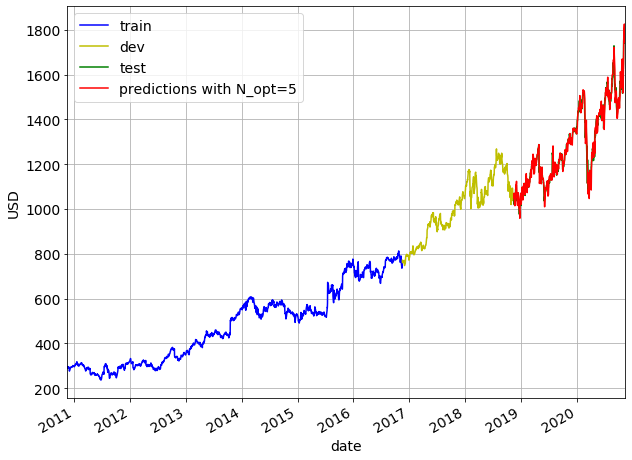

In [12]:

# Plot adjusted close over time  for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")


(737015.0, 737746.0)

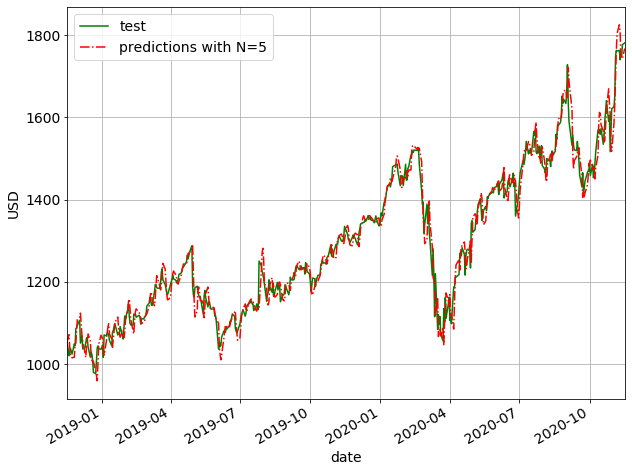

In [13]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='g-', grid=True)
ax = test.plot(x='date', y='est_N5', style='r-.', grid=True, ax=ax)
ax.legend(['test', 'predictions with N=5'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 11, 17), date(2020, 11, 17)])


In [3]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

import math
import matplotlib
import seaborn as sns

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

#### Input params ##################
stk_path = "C:/Users/KRITIKA/Documents/BIA-656-A/Project/GOOG.csv"

test_size = 0.2                
cv_size = 0.2                  
N = 3                      

fontsize = 14
ticklabelsize = 14



In [4]:
def get_mov_avg_std(df, col, N):
    
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled


In [5]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2010-11-17,291.407745,293.649323,289.599518,290.685425,290.685425,4903200,11
1,2010-11-18,293.400269,298.869751,293.181091,297.166138,297.166138,5199300,11
2,2010-11-19,297.385315,297.828674,294.067749,294.311859,294.311859,4612100,11
3,2010-11-22,292.638123,295.611969,290.286926,294.506104,294.506104,4389500,11
4,2010-11-23,292.408966,293.405243,288.020416,290.416443,290.416443,4341300,11


In [6]:
df.iloc[1511] #2016-11-17

date         2016-11-17 00:00:00
open                      766.92
high                       772.7
low                       764.23
close                     771.23
adj_close                 771.23
volume                   1304000
month                         11
Name: 1511, dtype: object

In [7]:
df.iloc[1511+503] #2018-11-16

date         2018-11-16 00:00:00
open                     1059.41
high                        1067
low                      1048.98
close                    1061.49
adj_close                1061.49
volume                   1658100
month                         11
Name: 2014, dtype: object

In [8]:
df.iloc[1511+503+502] #2020-11-16

date         2020-11-16 00:00:00
open                      1771.7
high                     1799.07
low                      1767.69
close                    1781.38
adj_close                1781.38
volume                   1245100
month                         11
Name: 2516, dtype: object

# Feature Engineering
We will generate the following features:

Mean 'adj_close' of each month
Difference between high and low of each day
Difference between open and close of each day
Mean volume of each month

In [9]:
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2010-11-17,290.685425,4903200,11,4.049805,0.722320
1,2010-11-18,297.166138,5199300,11,5.688660,-3.765869
2,2010-11-19,294.311859,4612100,11,3.760925,3.073456
3,2010-11-22,294.506104,4389500,11,5.325043,-1.867981
4,2010-11-23,290.416443,4341300,11,5.384827,1.992523


In [10]:
#Now we use lags up to N number of days to use as features.

df['order_day'] = [x for x in list(range(len(df)))]
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day
0,2010-11-17,290.685425,4903200,11,4.049805,0.722320,0
1,2010-11-18,297.166138,5199300,11,5.688660,-3.765869,1
2,2010-11-19,294.311859,4612100,11,3.760925,3.073456,2
3,2010-11-22,294.506104,4389500,11,5.325043,-1.867981,3
4,2010-11-23,290.416443,4341300,11,5.384827,1.992523,4


In [11]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)
    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2010-11-22,294.506104,4389500,11,5.325043,-1.867981,3,294.311859,3.760925,3.073456,4612100.0,297.166138,5.688660,-3.765869,5199300.0,290.685425,4.049805,0.722320,4903200.0
4,2010-11-23,290.416443,4341300,11,5.384827,1.992523,4,294.506104,5.325043,-1.867981,4389500.0,294.311859,3.760925,3.073456,4612100.0,297.166138,5.688660,-3.765869,5199300.0
5,2010-11-24,296.374115,4810600,11,4.757172,-3.815704,5,290.416443,5.384827,1.992523,4341300.0,294.506104,5.325043,-1.867981,4389500.0,294.311859,3.760925,3.073456,4612100.0
6,2010-11-26,293.898407,2632000,11,2.978851,0.229126,6,296.374115,4.757172,-3.815704,4810600.0,290.416443,5.384827,1.992523,4341300.0,294.506104,5.325043,-1.867981,4389500.0
7,2010-11-29,289.968140,5740800,11,4.906616,3.516815,7,293.898407,2.978851,0.229126,2632000.0,296.374115,4.757172,-3.815704,4810600.0,290.416443,5.384827,1.992523,4341300.0


In [12]:

cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2010-11-22,294.506104,4389500,11,5.325043,-1.867981,3,294.311859,3.760925,3.073456,...,0.722320,4903200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-11-23,290.416443,4341300,11,5.384827,1.992523,4,294.506104,5.325043,-1.867981,...,-3.765869,5199300.0,294.506104,NaN,5.325043,NaN,-1.867981,NaN,4.389500e+06,NaN
5,2010-11-24,296.374115,4810600,11,4.757172,-3.815704,5,290.416443,5.384827,1.992523,...,3.073456,4612100.0,292.461274,2.891827,5.354935,0.042274,0.062271,2.729789,4.365400e+06,3.408255e+04
6,2010-11-26,293.898407,2632000,11,2.978851,0.229126,6,296.374115,4.757172,-3.815704,...,-1.867981,4389500.0,293.765554,3.047093,5.155681,0.346411,-1.230387,2.956141,4.513800e+06,2.581637e+05
7,2010-11-29,289.968140,5740800,11,4.906616,3.516815,7,293.898407,2.978851,0.229126,...,1.992523,4341300.0,293.562988,2.992966,4.373617,1.248005,-0.531352,2.977855,3.927967e+06,1.146607e+06


In [13]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1510
num_cv = 502
num_test = 502
train.shape = (1510, 27)
cv.shape = (502, 27)
train_cv.shape = (2012, 27)
test.shape = (502, 27)


In [14]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()


scaler.mean_ = [4.82814587e+02 4.82505827e+02 8.14564533e+00 1.59458386e-01
 3.71592848e+06 4.82191877e+02 8.14380336e+00 1.59818736e-01
 3.71850815e+06 4.81878106e+02 8.13598868e+00 1.66442768e-01
 3.72078007e+06]
scaler.var_ = [2.70670700e+04 2.70394262e+04 2.77175826e+01 3.39238856e+01
 7.23857244e+12 2.70068702e+04 2.77215073e+01 3.39208604e+01
 7.23617042e+12 2.69782870e+04 2.76932183e+01 3.38620131e+01
 7.23375426e+12]
train_scaled.shape = (1510, 13)
train_scaled.shape = (1510, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.144588,-1.144477,-0.832845,0.500307,0.333092,-1.125888,-0.466303,-0.674035,0.550478,-1.164030,-0.776482,0.095526,0.439633,2010-11-22,11
1,-1.169446,-1.143295,-0.535752,-0.348093,0.250356,-1.143256,-0.832436,0.500267,0.332189,-1.124574,-0.465056,-0.675759,0.549725,2010-11-23,11
2,-1.133234,-1.168166,-0.524397,0.314720,0.232440,-1.142074,-0.535365,-0.348170,0.249438,-1.141951,-0.831376,0.499563,0.331399,2010-11-24,11
3,-1.148282,-1.131935,-0.643615,-0.682499,0.406872,-1.166960,-0.524010,0.314673,0.231520,-1.140768,-0.534153,-0.349611,0.248635,2010-11-26,11
4,-1.172171,-1.146991,-0.981394,0.011961,-0.402879,-1.130707,-0.643220,-0.682591,0.405980,-1.165667,-0.522793,0.313808,0.230714,2010-11-29,11


In [15]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [6.12544312e+02 6.12163011e+02 1.03435979e+01 6.88182942e-02
 3.18340075e+06 6.11781528e+02 1.03265097e+01 7.68869478e-02
 3.18507232e+06 6.11407286e+02 1.03168109e+01 7.40948772e-02
 3.18673101e+06]
scaler_train_cv.var_ = [7.52546054e+04 7.52046189e+04 6.63567647e+01 6.47226914e+01
 6.39957563e+12 7.51520003e+04 6.59280495e+01 6.45297572e+01
 6.40069044e+12 7.51104009e+04 6.58604439e+01 6.45104604e+01
 6.40085183e+12]
train_cv_scaled.shape = (2012, 13)
train_cv_scaled.shape = (2012, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.159345,-1.159048,-0.808090,0.373477,0.564762,-1.147651,-0.571191,-0.478369,0.796150,-1.170250,-0.772232,0.080707,0.678449,2010-11-22,11
1,-1.174253,-1.158340,-0.616079,-0.240744,0.476768,-1.158062,-0.808608,0.373030,0.564052,-1.146603,-0.570289,-0.478093,0.795485,2010-11-23,11
2,-1.152536,-1.173253,-0.608739,0.239117,0.457715,-1.157354,-0.615974,-0.242109,0.476066,-1.157018,-0.807828,0.373434,0.563389,2010-11-24,11
3,-1.161560,-1.151528,-0.685790,-0.482847,0.643228,-1.172272,-0.608611,0.238470,0.457014,-1.156309,-0.615095,-0.241797,0.475405,2010-11-26,11
4,-1.175887,-1.160556,-0.904097,0.019926,-0.217968,-1.150540,-0.685912,-0.484572,0.642512,-1.171231,-0.607728,0.238853,0.456353,2010-11-29,11


In [16]:
# Do scaling for set set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
cv_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1513,2016-11-21,-0.902050,1.075308,-0.173258,0.468893,-1.148287,0.679394,1.121737,-0.323634,-0.798102,0.850004,-1.101847,0.251843
1514,2016-11-22,0.389271,-1.136098,0.746827,-0.487687,1.150277,-0.662590,-0.693555,1.146300,-0.452745,-0.474726,1.148942,-0.674216
1515,2016-11-23,0.476775,0.672389,-1.149164,-0.437161,-0.706983,1.144144,0.169590,-1.073951,0.904361,0.733606,-1.139051,0.405445
1516,2016-11-25,-1.148507,0.470823,0.677685,1.129455,-0.356766,-0.772689,0.736590,0.401819,-1.138409,0.083842,0.955440,-1.039281
1517,2016-11-28,-0.489371,-0.661066,1.150438,-1.079650,0.894461,0.185188,-0.948636,1.044465,-0.095829,-1.148418,0.470036,0.678382


In [17]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
test_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2015,2018-11-19,0.429508,0.713493,-1.143001,-0.801906,1.120474,-0.318568,0.235399,-1.096699,0.861300,-0.208225,1.087719,-0.879494
2016,2018-11-20,-1.152291,0.511580,0.640711,0.727288,-1.140361,0.413072,1.099218,-0.243358,-0.855860,0.676735,-1.148628,0.471893
2017,2018-11-21,-0.444459,-0.700724,1.145182,0.219485,0.872026,-1.091511,-0.908163,1.071681,-0.163518,1.119861,-0.316139,-0.803722
2018,2018-11-23,1.093688,-0.226087,-0.867601,-1.104544,0.260746,0.843798,-0.138136,-0.923751,1.061887,-0.890522,1.081836,-0.191314
2019,2018-11-26,-0.699007,1.145457,-0.446450,-0.573099,-0.581591,1.154690,0.772663,0.356799,-1.129463,-0.986069,-0.027302,1.013372


In [18]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1510, 12)
y_train.shape = (1510,)
X_cv.shape = (502, 12)
y_cv.shape = (502,)
X_train_cv.shape = (2012, 12)
y_train_cv.shape = (2012,)
X_sample.shape = (502, 12)
y_sample.shape = (502,)


In [19]:
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1510, 12)
y_train_scaled.shape = (1510,)
X_cv_scaled.shape = (502, 12)
X_train_cv_scaled.shape = (2012, 12)
y_train_cv_scaled.shape = (2012,)
X_sample_scaled.shape = (502, 12)


Text(0.5, 1.0, 'Without scaling')

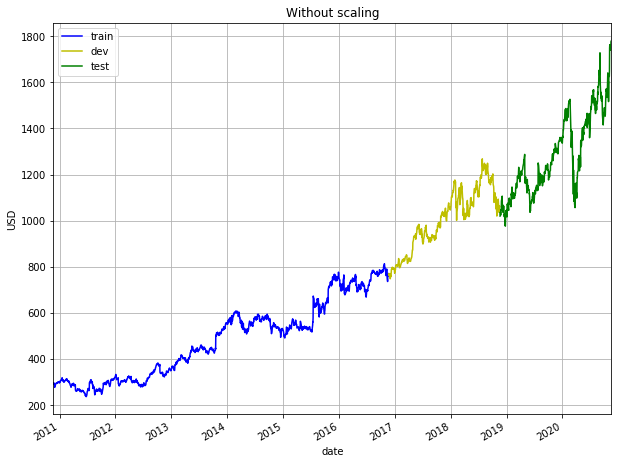

In [20]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

# Random Forest

In [21]:
# Create the model

model = RandomForestRegressor()

#modelLR=LinearRegression()
# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

#modelLR.fit(X_train_scaled, y_train_scaled)

RandomForestRegressor()

In [22]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

#est_scaledLR = modelLR.predict(X_train_scaled)
#estLR = est_scaledLR * math.sqrt(scaler.var_[0]) + scaler.mean_[0]


# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))
#print("RMSE on train set LR = %0.3f" % math.sqrt(mean_squared_error(y_train, estLR)))




RMSE on train set = 3.152


Text(0.5, 1.0, 'Without scaling')

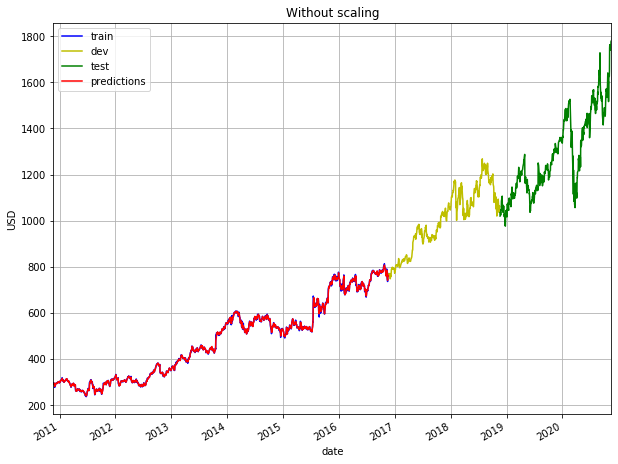

In [23]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [24]:
# Do prediction on CV set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)


RMSE on dev set = 14.412


Text(0, 0.5, 'USD')

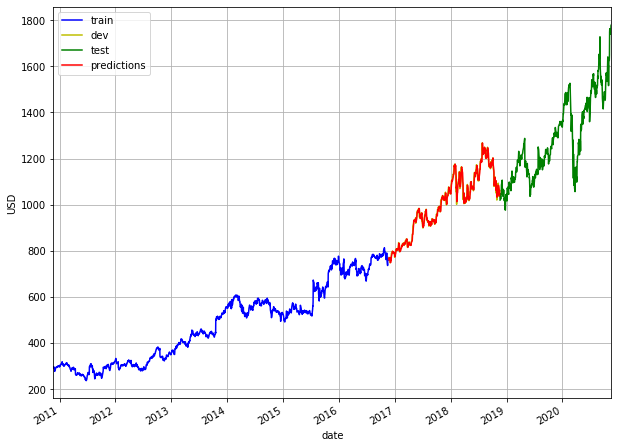

In [25]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [26]:

#Training using train cv scaled and predicting y_test

model.fit(X_train_cv_scaled, y_train_cv_scaled)

est_scaled=model.predict(X_sample_scaled)

est = est_scaled * test['adj_close_std'] + test['adj_close_mean']
rmse= math.sqrt(mean_squared_error(y_sample, est))

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)


RMSE on test set = 26.240


In [27]:
#RSquare values
# correlation_matrix = np.corrcoef(x_values, y_values)
# correlation_xy = correlation_matrix[0,1]
# r_squared = correlation_xy**2

from sklearn.metrics import r2_score
r_square_RF = r2_score(y_sample, est)
r_square_RF

0.9783288860574675

In [28]:
est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

Text(0, 0.5, 'USD')

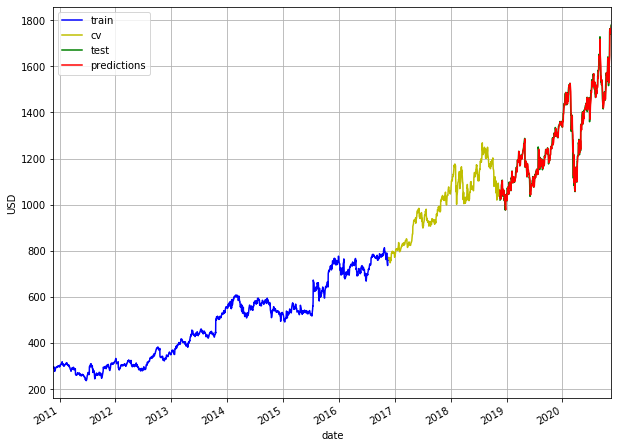

In [29]:
#Plotting train, cv, test and test prediction

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'cv', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")



Text(0.5, 1.0, 'Zoom in to Test set')

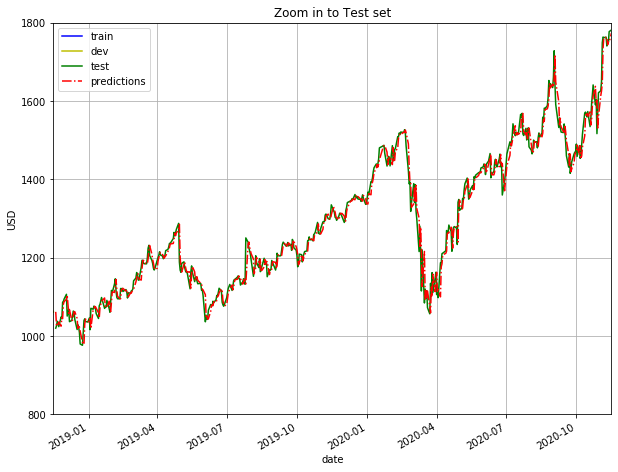

In [30]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-.', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018,11,16), date(2020,11, 16)])
ax.set_ylim([800,1800])
ax.set_title("Zoom in to Test set")

# Linear Regression

In [31]:
# Create the model

model = LinearRegression()

#modelLR=LinearRegression()
# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

#modelLR.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [32]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

#est_scaledLR = modelLR.predict(X_train_scaled)
#estLR = est_scaledLR * math.sqrt(scaler.var_[0]) + scaler.mean_[0]


# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))
#print("RMSE on train set LR = %0.3f" % math.sqrt(mean_squared_error(y_train, estLR)))


RMSE on train set = 7.548


Text(0.5, 1.0, 'Without scaling')

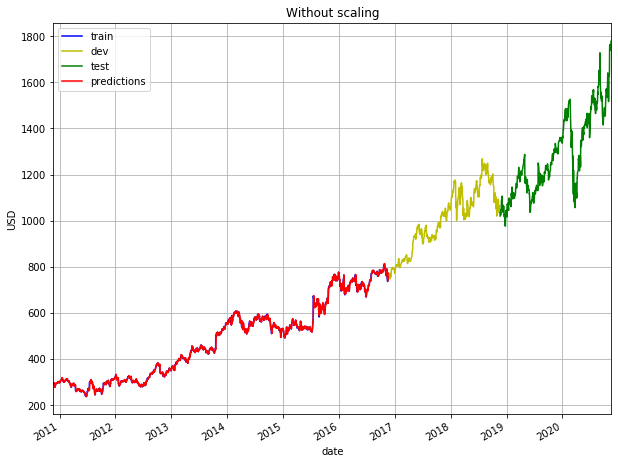

In [33]:
# Plot adjusted close over time for train set prediction
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [34]:
# Prediction on CV set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)


RMSE on dev set = 14.044


Text(0, 0.5, 'USD')

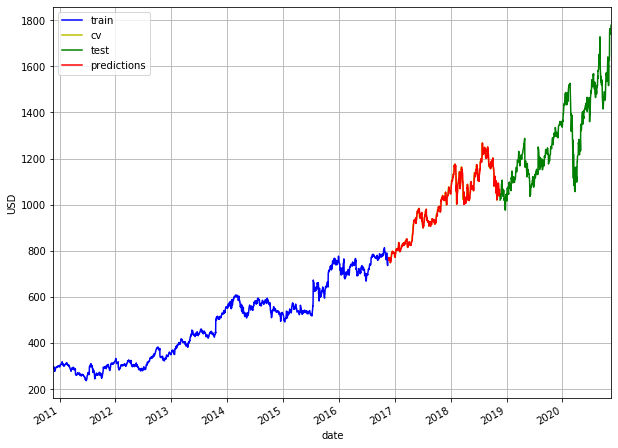

In [35]:
# Plot adjusted close over time for cv set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'cv', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [36]:
#Training using train cv scaled and predicting y_test


model.fit(X_train_cv_scaled, y_train_cv_scaled)

est_scaled=model.predict(X_sample_scaled)

est = est_scaled * test['adj_close_std'] + test['adj_close_mean']
rmse= math.sqrt(mean_squared_error(y_sample, est))

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)



RMSE on test set = 27.303


In [39]:
from sklearn.metrics import r2_score
r_square_LR = r2_score(y_sample, est)
r_square_LR

0.9765374344394817

In [40]:
est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})


Text(0, 0.5, 'USD')

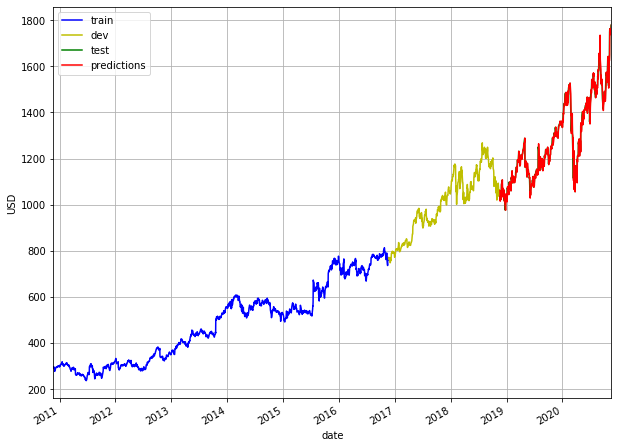

In [41]:
#Plotting adj close price for test set predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")



Text(0.5, 1.0, 'Zoom in to Test set')

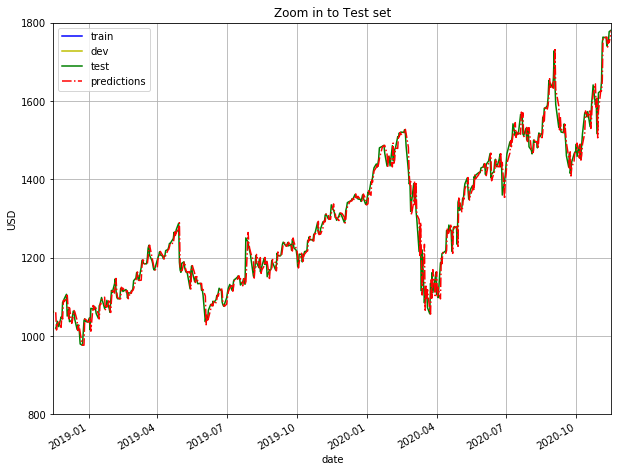

In [42]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-.', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018,11,16), date(2020,11, 16)])
ax.set_ylim([800,1800])
ax.set_title("Zoom in to Test set")

# XGBoost

In [43]:
# Create the model

model = XGBRegressor()

#modelLR=LinearRegression()
# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

#modelLR.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [44]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

#est_scaledLR = modelLR.predict(X_train_scaled)
#estLR = est_scaledLR * math.sqrt(scaler.var_[0]) + scaler.mean_[0]


# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))
#print("RMSE on train set LR = %0.3f" % math.sqrt(mean_squared_error(y_train, estLR)))


RMSE on train set = 0.806


Text(0.5, 1.0, 'Without scaling')

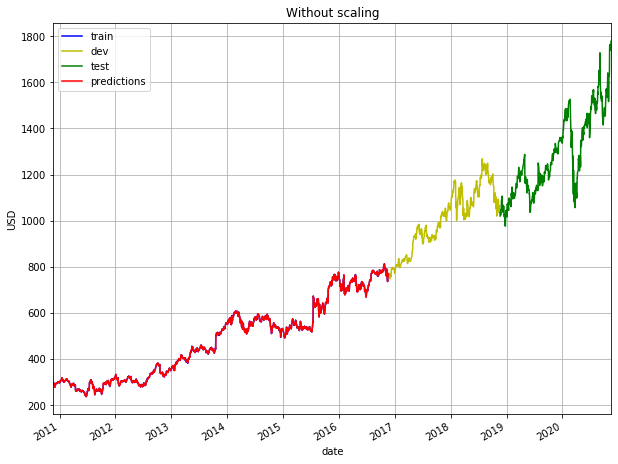

In [45]:
# Plot adjusted close over time for train set prediction
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [46]:
# Do prediction on CV set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)


RMSE on dev set = 14.126


Text(0, 0.5, 'USD')

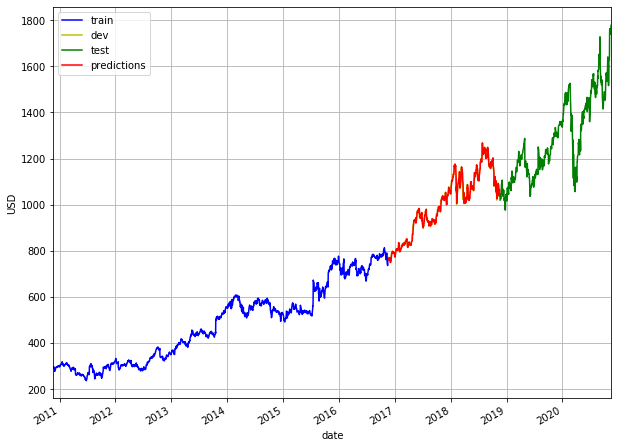

In [47]:
# Plot adjusted close over time for cv set prediction
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [48]:
#Training using train cv scaled and predicting y_test

model.fit(X_train_cv_scaled, y_train_cv_scaled)

est_scaled=model.predict(X_sample_scaled)

est = est_scaled * test['adj_close_std'] + test['adj_close_mean']
rmse= math.sqrt(mean_squared_error(y_sample, est))

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)


RMSE on test set = 26.339


In [49]:
from sklearn.metrics import r2_score
r_square_XG = r2_score(y_sample, est)
r_square_XG

0.9781656285092324

In [60]:
est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

Text(0, 0.5, 'USD')

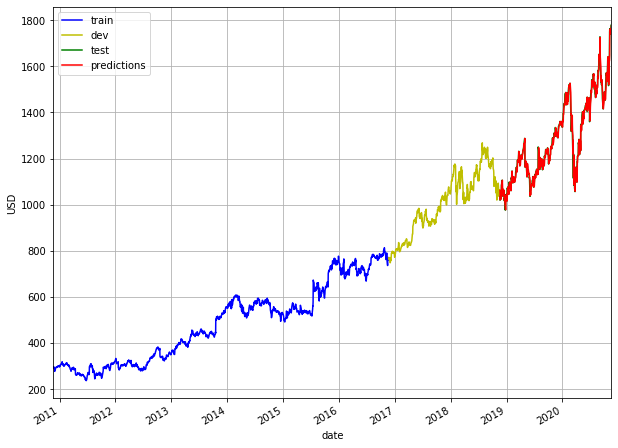

In [61]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to Test set')

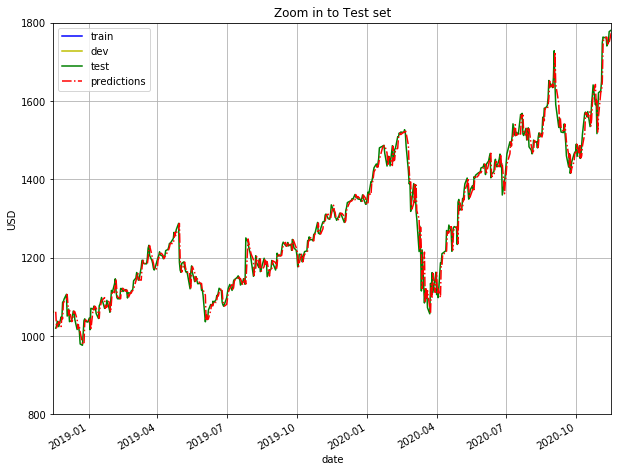

In [62]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-.', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018,11,16), date(2020,11, 16)])
ax.set_ylim([800,1800])
ax.set_title("Zoom in to Test set")